Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = "/content/drive/MyDrive/datasets/mit-bih-arrhythmia-database-modern-2023.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/mit-bih-data")

Mounted at /content/drive


In [ ]:
!pip install pandas neurokit2 ipywidgets mplcursors ipympl ipywidgets mplcursors -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00


Imports and File Paths

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import neurokit2 as nk
import plotly.graph_objects as go
from scipy.signal import find_peaks

patient_100_file = "/content/mit-bih-data/100_ekg.csv"
patient_100_info = "/content/mit-bih-data/100_annotations_1.csv"

Load


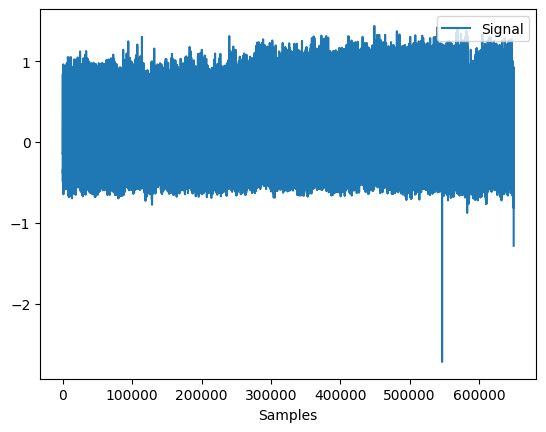

In [ ]:
ecg100 = pd.read_csv(patient_100_file, index_col=0)
ang100 = pd.read_csv(patient_100_info, index_col=0)

ecg100.head()
nk.signal_plot(ecg100['MLII'].values)  # initial ECG plot

Outliers

In [ ]:
threshold = 3  # 3 std
z = np.abs((ecg100['MLII'] - np.mean(ecg100['MLII'])) / np.std(ecg100['MLII']))
outliers = z > threshold
print(np.where(outliers)[0])


[    74     75     76 ... 649993 649994 649999]


Automated preprocessing

In [ ]:
SAMPLING_RATE = 360
signals, info = nk.ecg_process(ecg100['MLII'].values, sampling_rate=SAMPLING_RATE)

Merge annotations with preprocessed signals

In [ ]:
signals_labeled = signals.merge(
    ang100[['annotation_symbol']],
    left_index=True, right_index=True,
    how='left'
)

rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals_labeled["ECG_Clean"]


Plot ECG segment with R-peaks & annotations

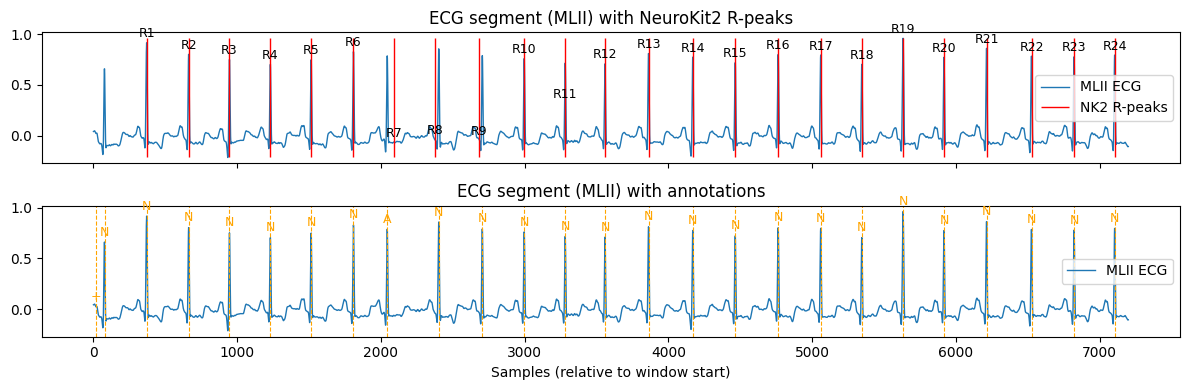

In [ ]:
fs = SAMPLING_RATE
num_heartbeats = 20
start, end = 0, num_heartbeats * fs
lead_type = "MLII"

segment = cleaned_ecg.loc[start:end].copy()
annotations = ang100.loc[start:end]

peaks_full = np.asarray(rpeaks)
peaks_in_window = peaks_full[(peaks_full >= start) & (peaks_full < end)]
peaks_shifted = peaks_in_window - start
peaks_shifted = peaks_shifted.astype(int)

ymin, ymax = np.min(segment), np.max(segment)
yrange = ymax - ymin
buffer = 0.05 * yrange
ylims = (ymin - buffer, ymax + buffer)

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].plot(segment.values, label=f"{lead_type} ECG", linewidth=1)
axes[0].vlines(peaks_shifted, ymin=ymin, ymax=ymax, colors='r', linewidth=1, label="NK2 R-peaks")
for i, p in enumerate(peaks_shifted):
    axes[0].text(p, segment.values[p] + 0.02 * yrange, f'R{i+1}', ha='center', va='bottom', fontsize=9)
axes[0].set_ylim(ylims)
axes[0].set_title(f'ECG segment ({lead_type}) with NeuroKit2 R-peaks')
axes[0].legend()

axes[1].plot(segment.values, label=f"{lead_type} ECG", linewidth=1)
for idx, row in annotations.iterrows():
    if 'annotation_symbol' in row and not pd.isna(row['annotation_symbol']):
        local_idx = idx - start
        if 0 <= local_idx < len(segment):
            axes[1].axvline(local_idx, color='orange', linestyle='--', linewidth=0.8)
            axes[1].text(local_idx, segment.values[local_idx] + 0.03 * yrange,
                         row['annotation_symbol'], color='orange', fontsize=9,
                         ha='center', va='bottom')
axes[1].set_ylim(ylims)
axes[1].set_title(f'ECG segment ({lead_type}) with annotations')
axes[1].set_xlabel('Samples (relative to window start)')
axes[1].legend()
plt.tight_layout()
plt.show()


Function for R-peak detection & plotting

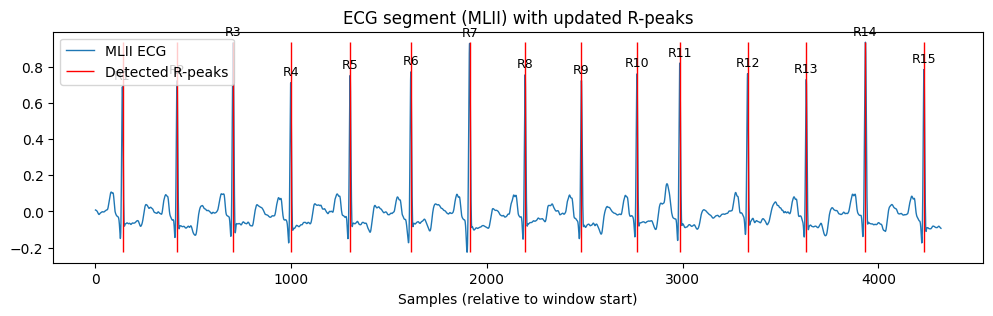

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


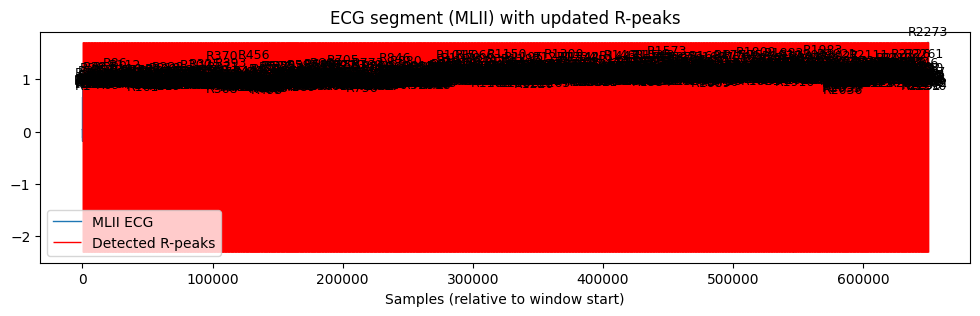

In [ ]:
def plot_ecg_rpeaks(cleaned_ecg, ang100, fs, start_sec=None, end_sec=None, lead_type="MLII"):
    if start_sec is None:
        start = 0
    else:
        start = int(start_sec * fs)
    if end_sec is None:
        end = len(cleaned_ecg) - 1
    else:
        end = int(end_sec * fs)

    segment = cleaned_ecg.loc[start:end].copy()
    annotations = ang100.loc[start:end]

    min_distance = int(0.25 * fs)
    min_r_peak_height = 0.5
    peak_height = max(np.mean(segment.values) + 0.3*np.std(segment.values), min_r_peak_height)
    peaks, _ = find_peaks(segment.values, distance=min_distance, height=peak_height)
    updated_rpeaks = {"ECG_R_Peaks": peaks}

    ymin, ymax = np.min(segment), np.max(segment)
    yrange = ymax - ymin
    buffer = 0.05 * yrange
    ylims = (ymin - buffer, ymax + buffer)

    plt.figure(figsize=(12, 3))
    plt.plot(segment.values, label=f"{lead_type} ECG", linewidth=1)
    plt.vlines(updated_rpeaks["ECG_R_Peaks"], ymin=ymin, ymax=ymax, colors='r', linewidth=1, label="Detected R-peaks")
    for i, p in enumerate(updated_rpeaks["ECG_R_Peaks"]):
        plt.text(p, segment.values[p] + 0.02 * yrange, f'R{i+1}', ha='center', va='bottom', fontsize=9)
    plt.ylim(ylims)
    plt.title(f'ECG segment ({lead_type}) with updated R-peaks')
    plt.xlabel('Samples (relative to window start)')
    plt.legend()
    plt.show()
    return updated_rpeaks

rpeaks_dict = plot_ecg_rpeaks(cleaned_ecg, ang100, fs=fs, start_sec=200, end_sec=212)
rpeaks_dict = plot_ecg_rpeaks(cleaned_ecg, ang100, fs=fs)

Heartbeat segmentation

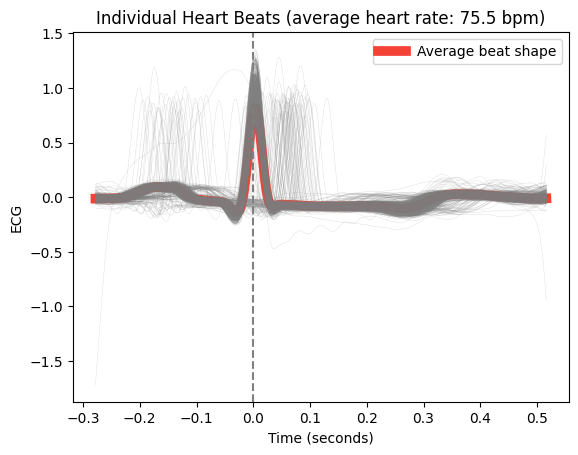

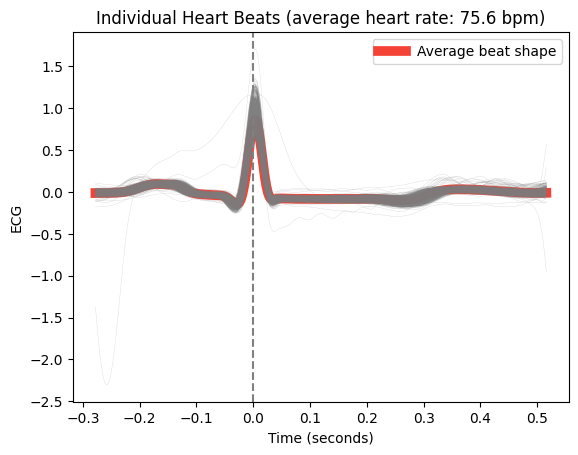

In [ ]:
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=rpeaks, sampling_rate=fs, show=True)
heartbeats = nk.ecg_segment(ecg_cleaned=signals['ECG_Clean'], rpeaks=rpeaks_dict['ECG_R_Peaks'], sampling_rate=fs, show=True)
heartbeats_df = nk.epochs_to_df(heartbeats)


Attach annotations


In [ ]:
rpeak_indices = rpeaks_dict["ECG_R_Peaks"]
beat_annotations = signals_labeled.loc[rpeak_indices, "annotation_symbol"].reset_index(drop=True)
beat_annotations.index = beat_annotations.index + 1
beat_annotations.index = beat_annotations.index.astype(str)
heartbeats_df["Annotation"] = heartbeats_df["Label"].map(beat_annotations)

heartbeats_pivoted = heartbeats_df.pivot(index="Time", columns="Label", values="Signal")

Normalize and clean beats

In [ ]:
heartbeats_df["Annotation"] = heartbeats_df["Annotation"].fillna("Unknown")
heartbeats_df["Signal_norm"] = heartbeats_df.groupby("Label")["Signal"].transform(
    lambda x: (x - np.mean(x)) / np.std(x)
)

beat_variance = heartbeats_df.groupby("Label")["Signal_norm"].var()
var_threshold = beat_variance.mean() + 3 * beat_variance.std()
outlier_beats = beat_variance[beat_variance > var_threshold].index
heartbeats_clean = heartbeats_df[~heartbeats_df["Label"].isin(outlier_beats)].copy()

def resample_beat(signal, n_points=200):
    x = np.linspace(0, 1, len(signal))
    f = scipy.interpolate.interp1d(x, signal)
    x_new = np.linspace(0, 1, n_points)
    return f(x_new)

resampled_beats = []
labels = heartbeats_clean["Label"].unique()
for label in labels:
    beat_signal = heartbeats_clean.loc[heartbeats_clean["Label"] == label, "Signal_norm"].values
    beat_resampled = resample_beat(beat_signal, n_points=200)
    resampled_beats.append(pd.DataFrame({f"Point_{i}": beat_resampled[i] for i in range(200)}, index=[label]))

beats_ready = pd.concat(resampled_beats)
label_to_annotation = heartbeats_clean.groupby("Label")["Annotation"].first()
beats_ready["Annotation"] = beats_ready.index.map(label_to_annotation)
beats_ready.reset_index(drop=True, inplace=True)

Fill missing annotations

In [ ]:
beats_filled = beats_ready.copy()
beats_filled["ptp"] = beats_filled.iloc[:, :-1].max(axis=1) - beats_filled.iloc[:, :-1].min(axis=1)

normal_ptp = beats_filled.loc[beats_filled["Annotation"] != "Unknown", "ptp"]
lower, upper = normal_ptp.mean() - 2*normal_ptp.std(), normal_ptp.mean() + 2*normal_ptp.std()
nan_mask = beats_filled["Annotation"] == "Unknown"
beats_filled.loc[nan_mask & (beats_filled["ptp"] >= lower) & (beats_filled["ptp"] <= upper), "Annotation"] = "N"
beats_filled.drop(columns="ptp", inplace=True)
print(beats_filled["Annotation"].value_counts())

Annotation
N          2219
A            30
Unknown      23
Name: count, dtype: int64


Visualization by annotation

In [ ]:
annotation_colors = {"N": "green", "A": "orange", "V": "red", "Unknown": "gray"}
fig = go.Figure()
for ann in beats_filled["Annotation"].unique():
    subset = beats_filled[beats_filled["Annotation"] == ann].iloc[:, :-1]
    if subset.empty:
        continue
    signals = subset.to_numpy()
    for beat in signals:
        fig.add_trace(go.Scattergl(
            y=beat, mode='lines',
            line=dict(color=annotation_colors.get(ann, "black"), width=1.5),
            showlegend=False
        ))
    fig.add_trace(go.Scattergl(
        y=[None], mode='lines',
        line=dict(color=annotation_colors.get(ann, "black"), width=1.5),
        name=ann
    ))
fig.update_layout(template="plotly_white",
                  title="Heartbeats grouped by annotation (after filling NaNs)",
                  xaxis_title="Sample index",
                  yaxis_title="Normalized signal")
fig.show()

Model

Classes distribution:
Annotation
N    2219
A      30
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.22      0.36         9
           N       0.99      1.00      0.99       666

    accuracy                           0.99       675
   macro avg       0.99      0.61      0.68       675
weighted avg       0.99      0.99      0.99       675

Confusion Matrix:


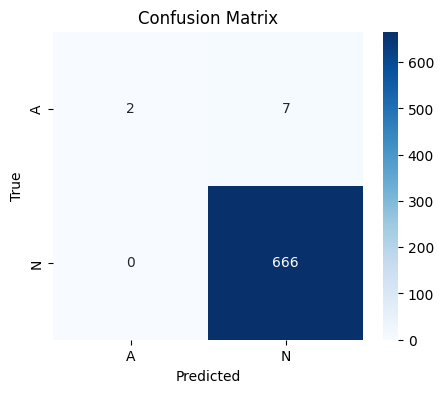

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# 1. Prepare Data
data_for_model = beats_filled[beats_filled["Annotation"] != "Unknown"].copy()

# Separate features (X) and target (y)
X = data_for_model.drop(columns=["Annotation"])
y = data_for_model["Annotation"]

print(f"Classes distribution:\n{y.value_counts()}")

# 2. Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Initialize and Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# 4. Predictions
y_pred = clf.predict(X_test)

# 5. Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()